# Google Earth Engine (GEE) DisALEXI 
## Single Landsat Collection 1 SR Image Example

Example of calling the GEE DisALEXI function on a single Landsat 8 Collection 1 surface
 reflectance image.

### Python imports and GEE initialization

In [1]:
import pprint

import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

# %load_ext autoreload
# %autoreload 2

pp = pprint.PrettyPrinter(indent=2)

In [2]:
# Geom for LC08_044033_20170614
test_xy = [-121.5265, 38.7399]
test_region = [[-121.62, 38.69], [-121.62, 38.78], [-121.43, 38.78], [-121.43, 38.69]]

# # Geom for LC08_038038_20150717
# test_xy = [-114.986, 32.355]
# test_region = [[-115.1, 32.3], [-115.1, 32.41], [-114.9, 32.41], [-114.9, 32.3]]

test_geom = ee.Geometry.Point(test_xy)
test_geom = ee.Geometry.Polygon(test_region)

In [3]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = '#EFE7E1,#003300'

### Start with a single Landsat 8 TOA image

In [4]:
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170716')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170614')
# landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038038_20150717')

# # Mosaic images into a single Landsat image
# landsat_a_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038037_20150717')
# landsat_b_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
# landsat_img = ee.Image(ee.ImageCollection([landsat_a_img, landsat_b_img]).mosaic()) \
#     .copyProperties(landsat_a_img, [
#         'system:time_start', 'system:index', 'SPACECRAFT_ID', 'SUN_ELEVATION', 
#         'K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'])
# landsat_image = ee.Image(landsat_image)
# pp.pprint(landsat_img.getInfo()['properties'])

In [5]:
# Extract geotransform and spatial reference
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
print(image_crs)
print(image_transform)

EPSG:32610
[30.0, 0.0, 501585.0, 0.0, -30.0, 4423515.0]


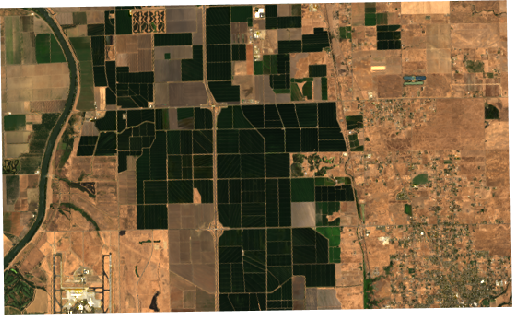

In [6]:
vis_image = ee.Image(landsat_img) \
    .visualize(bands=['B4', 'B3', 'B2'], min=[0, 0, 0], max=[3000, 3000, 3000]) \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .clip(test_geom)
Image(url=vis_image.getThumbURL(), embed=True, format='png')

### Prep the raw Landsat TOA image for use in DisALEXI

The prep function will rename the bands to generic names, compute albedo, ndvi, lai, and extract the fmask image from the BQA band.

In [7]:
input_img = ee.Image(landsat.LandsatSR(landsat_img).prep())

Show the NDVI band for the validation asset area

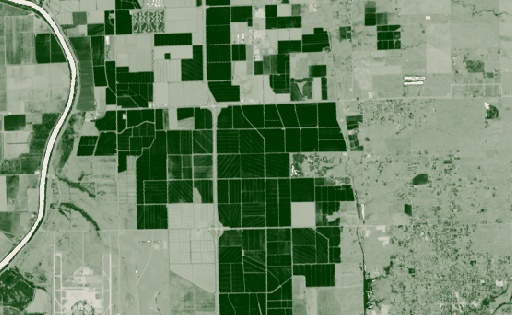

In [8]:
vis_img = input_img.select(['ndvi']).getThumbURL({
    'region': test_region, 'min':-0.1, 'max':0.9, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

### Extract input values at the test point

In [9]:
print('LAI:    {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['lai'])))
print('NDVI:   {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['lst'])))
print('CFMask: {:12.8f}'.format(float(utils.point_image_value(input_img, xy=test_xy, scale=30)['cfmask'])))

LAI:      4.67970025
NDVI:     0.87439299
Albedo:   0.12599610
LST:    305.92253851 [K]
CFMask:   0.00000000


### Initialize the DisALEXI object

In [10]:
# Initialize the DisALEXI object using all default values
# NLCD Landcover, NED Elevation, CONUS ALEXI ET
model_obj = disalexi.Image(
    input_img, 
    ta_source='CONUS_V001',
    alexi_source='CONUS_V001',
    elevation_source='USGS/SRTMGL1_003',
    landcover_source='NLCD2011',
    # landcover_source='GLOBELAND30',
    rs_daily_source='MERRA2',
    rs_hourly_source='MERRA2',
    windspeed_source='CFSV2',
    stabil_iterations=6,
    albedo_iterations=3,
    ta_interp_flag=True,
    ta_smooth_flag=True,
    rs_interp_flag=True,
    # etr_source=None,
    # etr_band=None,
    # etr_factor=None,
)

### Extract the ancillary values at the test point

In [11]:
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.point_image_value(model_obj.et_alexi, xy=test_xy, scale=30)['et_alexi'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.point_image_value(model_obj.elevation, xy=test_xy, scale=30)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.point_image_value(model_obj.rs1, xy=test_xy, scale=30)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.point_image_value(model_obj.rs24, xy=test_xy, scale=30)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.point_image_value(model_obj.windspeed, xy=test_xy, scale=30)['windspeed'])))

ALEXI ET:    10.33441734 [mm]
Elevation:    3.00000000 [m]
Rs Hourly:  946.69066528 [W m-2]
Rs Daily:  8603.21289062 [W m-2]
Wind Speed:   3.26653672 [m/s]


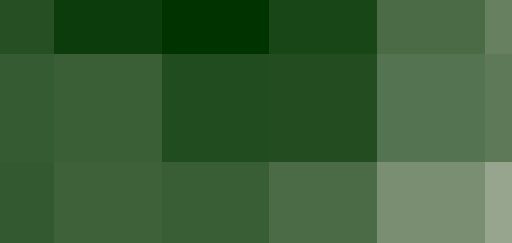

In [12]:
vis_img = model_obj.et_alexi.getThumbURL({
    'region': test_region, 'min':0, 'max':12, 
    'palette': ndvi_palette})
Image(url=vis_img, embed=True, format='png')

### Ta Asset ("smoothed" to Landsat scale)

In [13]:
ta_img = model_obj.ta
print('Ta: {}'.format(pprint.pformat(
    utils.point_image_value(ta_img, xy=test_xy, scale=30)['ta'])))

Ta: 295.95774630394834


In [14]:
ta_url = ta_img.getThumbURL({
    'region': test_region, 'min': 260, 'max': 310, 
    'palette': ','.join(ssebop_et_palette)})
# print(ta_url)

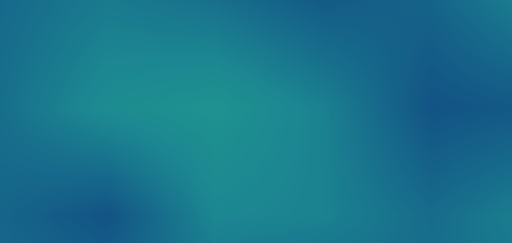

In [15]:
Image(url=ta_url, embed=True, format='png')

### Compute ET

In [16]:
et_img = model_obj.et
#     .reproject(crs=image_crs, crsTransform=image_transform)
print('ET: {}'.format(pprint.pformat(
    utils.point_image_value(et_img, xy=test_xy, scale=30)['et'])))

ET: 12.430703120327966


In [17]:
et_url = et_img.getThumbURL({
    'region': test_region, 'min': 0, 'max': 20, 
    'palette': ','.join(ssebop_et_palette)})
# print(et_url)

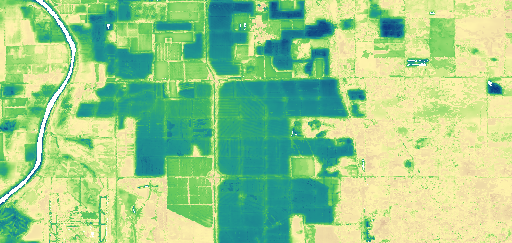

In [18]:
Image(url=et_url, embed=True, format='png')

### Ta Asset (ALEXI scale)

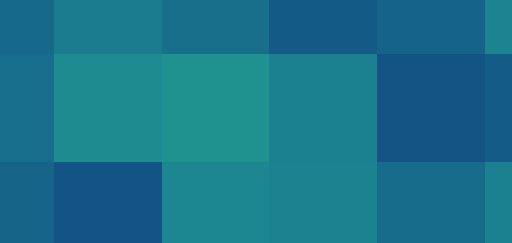

In [19]:
# Same as above but set ta_smooth_flag to False
model_obj = disalexi.Image(
    input_img, 
    ta_source='CONUS_V001',
    alexi_source='CONUS_V001',
    elevation_source='USGS/SRTMGL1_003',
    landcover_source='NLCD2011',
    # landcover_source='GLOBELAND30',
    rs_daily_source='MERRA2',
    rs_hourly_source='MERRA2',
    windspeed_source='CFSV2',
    stabil_iterations=6,
    albedo_iterations=3,
    ta_interp_flag=True,
    ta_smooth_flag=False,
)
ta_url = model_obj.ta.getThumbURL({
    'region': test_region, 'min': 260, 'max': 310, 
    'palette': ','.join(ssebop_et_palette)})
Image(url=ta_url, embed=True, format='png')

### Compute Air Temperature

In [20]:
# image_transform = ee.Image(landsat_img).select('B2').projection().getInfo()['transform']
# print(image_transform)

# # Reduce the computation resolution
# image_transform = '[' + ','.join(map(str, [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0])) + ']'
# # output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
# image_transform = [120.0, 0.0, 626985.0, 0.0, -120.0, 3629715.0]
# print(image_transform)

In [21]:
# t_air_img = ee.Image(model_obj.ta_qm(cellsize=120, ta_values=list(range(250, 351, 1))))
# print('Output Ta:\n{}'.format(pprint.pformat(
#     utils.image_value(t_air_img, xy=test_xy, scale=120)['ta'])))
# # print('Output Ta:\n{}'.format(pprint.pformat(
# #     utils.image_value(t_air_img, xy=test_xy, crs=image_crs, crsTransform=image_transform)['ta'])))

In [22]:
# t_air_url = t_air_img.getThumbURL({
#     'region': test_region, 'min':270, 'max':330})
# print(t_air_url)

In [23]:
# Image(url=t_air_url, embed=True, format='png')